<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/ransac/ransac_sik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Többszörös sík keresés

A pontfelhő állományokban általában nem csak egy geometriai alakzatot szeretnénk automatizáltan megtalálni, felismerni, hanem többet. Ebben az esetbenazt az eljárást követhetjük, hogy az első geometriai elem megtalálása után kivesszük az ahhoz tartozó pontokat az állományból és a megmaradó pontokon megismételsük az alakzat keresését.

Ebben a példában nem mi írjuk meg a RANSAC módszert síkra, hanem az Open3D Python modult használjuk.

In [1]:
!pip -q install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.3 MB/s eta 0:00:00


Egy épület pontjait tartalmazó kisebb pcd állományt használunk.

In [2]:
!wget -q https://github.com/OSGeoLabBp/tutorials/raw/master/english/data_processing/lessons/code/house.pcd -O sample_data/house.pcd

Keressük meg a pontfelhőben a nyolc (*n_planes*) síkot, melyekre a lehető legtöbb pont esik.

In [10]:
from math import atan2, hypot, pi
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go

1986 points left from 7190


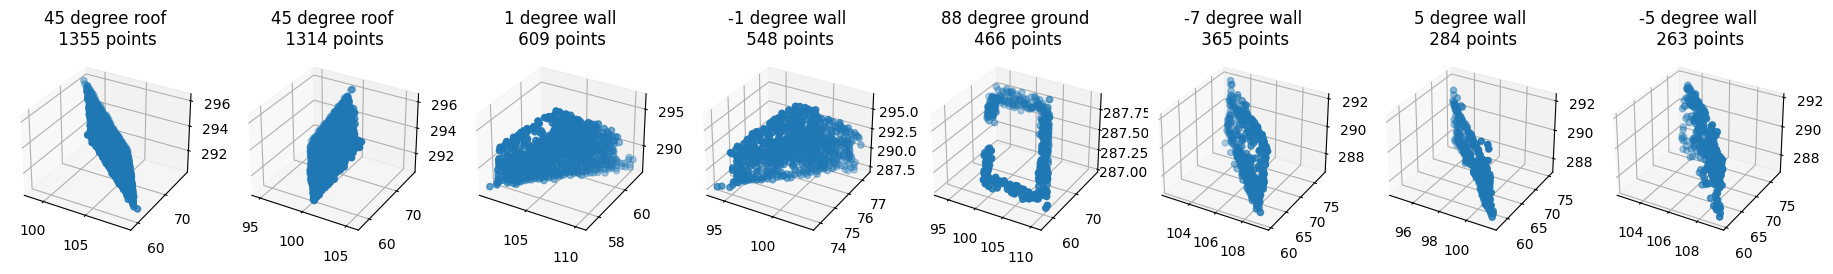

In [11]:
def label(ang):
    """ return roof/wall/ground label from angle of normal to horizontal """
    label = '???'
    if abs(ang < 15):
        label = 'wall'
    elif 80 < abs(ang) < 100:
        label = 'ground'
    elif 35 < abs(ang) < 55:
        label = 'roof'
    return label

n_planes = 8
tol = 0.1           # tolerance distance from plane
n_points = 3        # number of random points
iterations = 300
# load point cloud
pc = o3d.io.read_point_cloud('sample_data/house.pcd')
n_orig = len(pc.points)
pc_orig = pc.select_by_index([], invert=True)   # make a copy of original
planes = []     # list of result planes
fig = plt.figure(figsize=(23, 3))

i = 0
while i < n_planes:
    plane, inliers = pc.segment_plane(tol, n_points, iterations)
    angle = atan2(plane[2], hypot(plane[0], plane[1])) * 180. / pi  # angle of normal from horizontal
    plane_pc = pc.select_by_index(inliers)
    o3d.io.write_point_cloud('sample_data/plane_' + str(i) + '.pcd', plane_pc) # export planes
    ax = fig.add_subplot(1, n_planes, i+1, projection='3d')
    ax.set_title(f'{angle:.0f} degree {label(angle)}\n {len(inliers)} points')
    xyz = np.asarray(plane_pc.points)
    ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2])
    #ch = plane_pc.compute_convex_hull()
    planes.append([plane, plane_pc])
    pc = pc.select_by_index(inliers, invert=True)   # rest of the point cloud
    i += 1
print(f'{len(pc.points)} points left from {n_orig}')

Jelenítsük meg eltérő színekkel a megtalált nyolc síkot!

In [12]:
data = []
colors = ['red', 'blue', 'green', 'cyan', 'yellow', 'magenta', 'brown', 'orange']
for i, pp in enumerate(planes):
    xyz = np.asarray(pp[1].points)
    data.append(go.Scatter3d(x=xyz[:, 0], y=xyz[:, 1], z=xyz[:, 2], mode='markers',
                             marker=dict(size=1, color=colors[i % len(planes)])))
fig = go.Figure(data=data)
fig.update_layout(scene=dict(aspectmode='manual', aspectratio=dict(x=1, y=1, z=1),
                    xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                    width=700, margin=dict(r=20, b=10, l=10, t=10))
fig.update_layout(showlegend=False)
fig.show()